## Environment

In [29]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import chisquare

from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error as MSE
from sklearn.metrics import precision_recall_fscore_support as report
from sklearn.preprocessing import StandardScaler

import helpers as hlp
%aimport helpers
import settings
from data.preprocessing import load_file,save_file,filter_by_season,get_scaled_series,encode
%aimport data.preprocessing

pd.options.display.max_rows = 10

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

row_headers=["Product"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feature Engineering

In [3]:
! python c:/Users/rahmim00/Documents/Notebooks/Clustering/pc_clustering/src/features/build_features.py

2018-07-13 09:57:41,608 - __main__ - INFO - Load raw sales file...
2018-07-13 09:57:41,623 - __main__ - INFO - Load product description file...
2018-07-13 09:57:41,971 - __main__ - INFO - Load clients count  file...
2018-07-13 09:57:41,986 - __main__ - INFO - Feature engineering...
2018-07-13 09:57:42,221 - __main__ - INFO - ==> Saving features file to clf_features ...
2018-07-13 09:57:42,267 - __main__ - INFO - Creating encoders...
2018-07-13 09:57:42,392 - __main__ - INFO - Data set succefully made !


In [223]:
s = "Autumn"
v = 3
clustering_model = "nb_p2_clusters_%s"%(s)

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
zclean_df,_ =  get_scaled_series(sclean_df)

#clustering result
cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = 1)

#cleaned features
features_df = load_file('clf_features',type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))

numeric = (list(features_df.columns.to_series().groupby(features_df.dtypes).groups[np.dtype('float64')]))
features_list = list(features_df.columns) + ["Cluster"]
df = features_df.join(cluster_df,how="inner")[features_list]


print(df.shape)
clean_df.head(2)

(1046, 12)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,0.5,4.0,9.0,9.0,6.0,4.0,4.5,3.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
30E000400_2,34.0,230.0,507.0,569.5,493.0,445.5,513.5,514.0,388.0,320.5,249.5,161.5,98.5,70.5,44.5,31.5


## Classification Models

In [224]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.tree import  export_graphviz
import subprocess


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=True )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")


features_df = df[features_list].copy()
data = features_df.copy()
data["Sales Season"] = s
print(data.shape)
display(data.head())

(1046, 12)


,Color,Size,Ldate,Age Group,Person,Pname,Ptype,Tprice,Currency,Sales Season,Nstore,Cluster
Product,,,,,,,,,,,,
3.6E+101_2,Other,Thick,36,29-38,Pregnant,One-Piece Pants,Thin,0.134078,Y,Autumn,0.005995,7
31C000963_2,Black,Sheer,40,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.402878,7
31C002201_2,Grey,No Size,36,18-28,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.031175,4
31C002300_2,Black,Sheer,43,29-38,Female,One-Piece Pants Inside,Thin,0.078212,$,Autumn,0.406475,7
31C002400_2,Black,Sheer,37,29-38,Female,One-Piece Pants Inside,Thin,0.106145,$,Autumn,0.411271,4


In [225]:
X = encode(data.drop(["Cluster"],axis=1),non_categorical = numeric)
feature_labels = X.columns
y = data["Cluster"]
print(X.shape)

series = clean_df.iloc[:,:3].copy()
series = series.apply(lambda x:x / x.std())

classifier = RandomForestClassifier(n_estimators=100,max_depth=12)

X.head(3)


(1046, 160)


,Age Group_10-15,Age Group_18-28,Age Group_29-38,Age Group_39-48,Age Group_4-6,Age Group_7-9,Color_Black,Color_Blue,Color_Brown,Color_Green,...,Ldate_50,Ldate_51,Ldate_52,Ldate_53,Ldate_6,Ldate_7,Ldate_8,Ldate_9,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.005995
31C000963_2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.078212,0.402878
31C002201_2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.078212,0.031175


## Standard evaluation metrics of the algorithm

In [228]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

classifier = RandomForestClassifier(n_estimators=80,max_depth=18,min_samples_split=2, min_samples_leaf=1, criterion='gini', bootstrap=True)

# scores = cross_val_score(classifier, X, y, cv=2, scoring='f1_macro')
# print(scores,scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)
yt_pred = classifier.predict(X_train)

print("Train")
print(classification_report(y_train,yt_pred,labels=np.unique(y_test) )[-54*1:])
print("Test")
print(classification_report(y_test,y_pred,labels=np.unique(y_test) )[-54*1:])

Train

avg / total       0.98      0.98      0.98       836

Test

avg / total       0.47      0.45      0.45       210



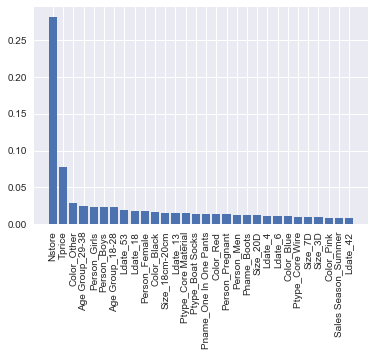

In [229]:
fi = classifier.feature_importances_
sorted_indices = np.argsort(fi)[::-1]

imp = sorted_indices[:30]

plt.bar(range(len(imp)),fi[imp])
plt.xticks(range(len(imp)), feature_labels[imp],rotation = 90)
plt.show()

### Grid Search

## RMSE to the center of the predicted cluster 
#### Joining the series with the predicted clusters of the test set

In [243]:
import imp

from visualization import classification_analysis as ca
%aimport visualization.classification_analysis
imp.reload(settings)
imp.reload(visualization.classification_analysis)

<module 'visualization.classification_analysis' from 'C:\\Users\\rahmim00\\Documents\\Notebooks\\Clustering\\pc_clustering\\src\\visualization\\classification_analysis.py'>

In [245]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")

print(full_series.shape)
display(full_series.sort_index().head().iloc[:,:])


(210, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C180301_2,9,8,5,4,331032200_2,337015200_2,335025200_2,336012400_2,6,331700300_2,...,39.0,33.0,13.0,45.0,45.0,84.0,47.0,43.0,9.0,12.0
31C999909_2,10,8,3,4,338009400_2,337015200_2,326260000_2,336012400_2,2,331051800_2,...,129.0,232.0,503.0,432.0,400.0,454.0,278.0,432.0,287.0,253.0
325028800_2,12,7,11,10,331032500_2,335011700_2,335846800_2,338009400_2,11,335846800_2,...,1.0,0.0,21.0,17.0,23.0,9.0,22.0,7.0,9.0,1.0
325029700_2,11,6,2,7,335846800_2,331700300_2,331051800_2,335011700_2,11,335846800_2,...,0.0,4.0,2.0,4.0,11.0,6.0,3.0,0.0,0.0,1.0
325030800_2,7,12,10,3,335011700_2,331032500_2,338009400_2,326260000_2,6,331700300_2,...,19.0,18.0,11.0,7.0,12.0,12.0,12.0,3.0,2.0,0.0


### Top-4 Error rate and correlation

In [231]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))



offset = (n_pred * 2) + 2
guess = 2

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
RMSE = []
PRMSE = []
CORR = []
SP=[]
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    rmse = math.sqrt(MSE(series,c_series)/n)
    prmse = math.sqrt(MSE(series,predicted_series)/n)
    corr = np.corrcoef(series,predicted_series)[0][1]
    
    RMSE.append(rmse)
    PRMSE.append(prmse)
    CORR.append(corr)
    i+=1
    
  
sales = p_series.values[:,offset:].astype(np.float64)
p_series["PRMSE"] = PRMSE
p_series["RMSE"] = RMSE
p_series["CORR"] = CORR
results = pd.DataFrame(index = p_series.index)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = RMSE
results["PRMSE"] = PRMSE
results["CORR"] = CORR


print("%.2f have less than 70%% correlation between predicted and actual series"%(results[results.CORR<0.7].shape[0]/N*100))


results[results.PRMSE != results.RMSE].nlargest(210,"PRMSE").head(5)

20.00 Not in Top 4 guesses
72.86 have less than 70% correlation between predicted and actual series


,Mean,Std,Range,RMSE,PRMSE,CORR
Product,,,,,,
335970868_2,9051.0625,4876.873723,13787.0,2431.947776,2519.535544,0.357570
332979751_2,5660.1250,6566.147728,24704.0,2082.750777,2151.586767,-0.129562
325061603_2,0.5625,0.704339,2.0,31.032304,484.198678,-0.460036
325176900_2,0.8125,0.526634,2.0,0.755190,484.138071,-0.508331
336014100_2,5.1250,8.290620,24.0,44.939630,483.872849,-0.627492


### Predictions Plots

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
335970868_2,1,10,8,4,331050900_2,338009400_2,337015200_2,336012400_2,1,331050900_2,...,12192.0,13581.0,9018.0,10978.0,7605.0,13602.0,10661.0,12140.0,13884.0,12085.0
332979751_2,2,7,4,8,331051800_2,335011700_2,336012400_2,337015200_2,5,335025200_2,...,24965.0,7888.0,4882.0,3919.0,2861.0,3766.0,2865.0,3212.0,2270.0,2045.0
325061603_2,12,2,7,5,331032500_2,331051800_2,335011700_2,335025200_2,6,331700300_2,...,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
325176900_2,12,2,3,10,331032500_2,331051800_2,326260000_2,338009400_2,3,326260000_2,...,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
336014100_2,5,2,11,9,335025200_2,331051800_2,335846800_2,331032200_2,7,335011700_2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


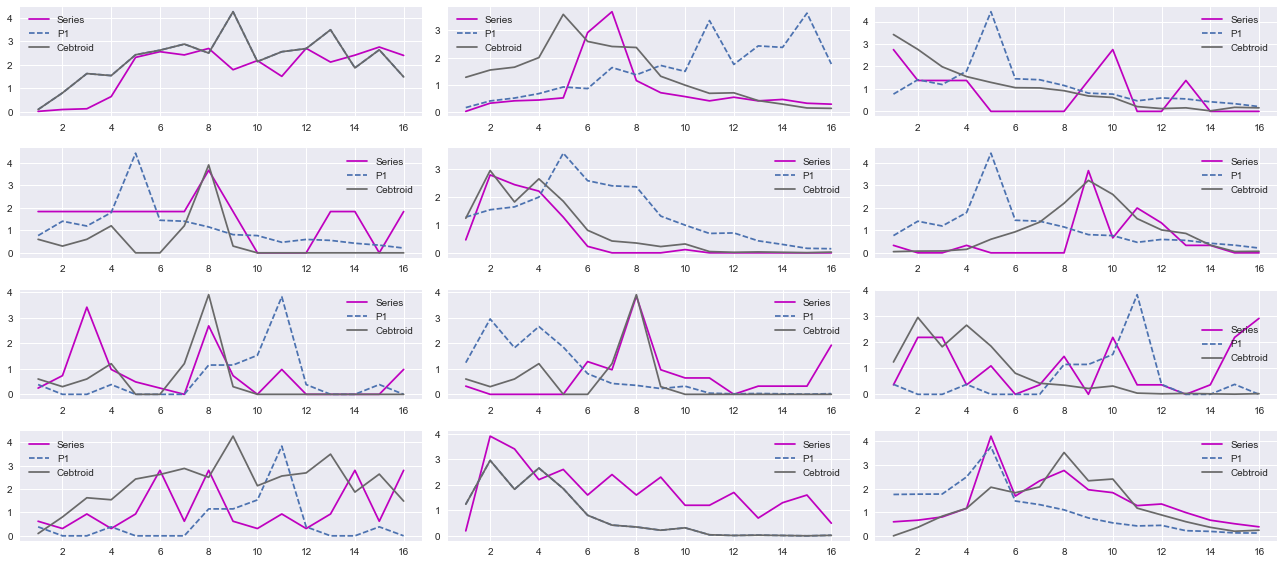

In [232]:
bad = p_series[p_series.PRMSE != p_series.RMSE].nlargest(210,"PRMSE")
good = p_series[p_series.CORR>0.8]


disp = p_series.iloc[:,:-3].loc[bad.index[:12]]
display(disp.head())




plt.figure(figsize=(18,2 * 4))
i=1;
for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(predicted_series,label="P1",ls='--')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
    #plt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities
### Load features and predictor

In [233]:
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

features_df = load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))


from sklearn.externals import joblib


features_df.head()
encoded_df = encode(features_df,non_categorical = ["Tprice","Nstore"])

encoded_df.head()

,Age Group_10-15,Age Group_18-28,Age Group_29-38,Age Group_39-48,Age Group_4-6,Age Group_7-9,Color_Black,Color_Blue,Color_Brown,Color_Green,...,Ldate_50,Ldate_51,Ldate_52,Ldate_53,Ldate_6,Ldate_7,Ldate_8,Ldate_9,Tprice,Nstore
Product,,,,,,,,,,,,,,,,,,,,,
3.6E+101_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.134078,0.005995
30E000400_2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.106145,0.387290
30E823101_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.081535
30E823102_2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.082734
30E823103_2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.106145,0.081535


count    210.000000
mean      -1.231703
std        7.040195
min      -81.505215
25%       -0.410336
50%       -0.006669
75%        0.411666
max        0.928355
Name: R2, dtype: float64

0.5


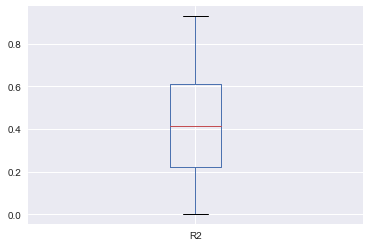

In [234]:
predictor = joblib.load(models_path+'regressor_std.pkl')

disp = p_series.iloc[:,:-3].loc[results.index[0:12]]
disp = p_series.iloc[:,:-3]

R2 = []
RMSE = []
BEST = []
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    rmse1 = math.sqrt(MSE(p1,series)/n)
    rmse2 = math.sqrt(MSE(p2,series)/n)
    rmse3 = math.sqrt(MSE(p3,series)/n)
    rmse4 = math.sqrt(MSE(p4,series)/n)
    
    r2_1 = r2_score(p1,series,multioutput="uniform_average")
    r2_2 = r2_score(p2,series,multioutput="uniform_average")
    r2_3 = r2_score(p3,series,multioutput="uniform_average")
    r2_4 = r2_score(p4,series,multioutput="uniform_average")
    
    r2 = [r2_1,r2_2,r2_3,r2_4]
    rmse = [rmse1,rmse2,rmse3,rmse4]
    best = np.argmin(rmse)
    
    BEST.append(best)
    R2.append(r2[best])
    RMSE.append(rmse[best])
    
disp["R2"] = R2
disp["RMSE"] = RMSE
disp["Best"] = BEST
display(disp.R2.describe())
disp[disp.R2>0].R2.plot(kind="box")
print(disp[disp.R2>0].R2.count()/disp.shape[0])
plt.show()

### Display First Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
345011800_2,9,5,8,12,331032200_2,335025200_2,337015200_2,331032500_2,9,331032200_2,...,31.0,12.0,12.0,13.0,4.0,1.0,2.0,0.928355,6.879047,0
331024300_2,9,7,1,8,331032200_2,335011700_2,331050900_2,337015200_2,9,331032200_2,...,69.0,62.0,59.0,35.0,27.0,23.0,11.0,0.869401,10.018708,0
335014500_2,9,7,5,6,331032200_2,335011700_2,335025200_2,331700300_2,9,331032200_2,...,17.0,9.0,7.0,5.0,1.0,0.0,1.0,0.869286,2.048750,0
331043000_2,12,9,7,5,331032500_2,331032200_2,335011700_2,335025200_2,5,335025200_2,...,8.0,3.0,6.0,1.0,3.0,2.0,2.0,0.859749,0.749681,3
345010900_2,5,9,8,12,335025200_2,331032200_2,337015200_2,331032500_2,12,331032500_2,...,33.0,25.0,37.0,15.0,9.0,2.0,3.0,0.852791,8.910413,3


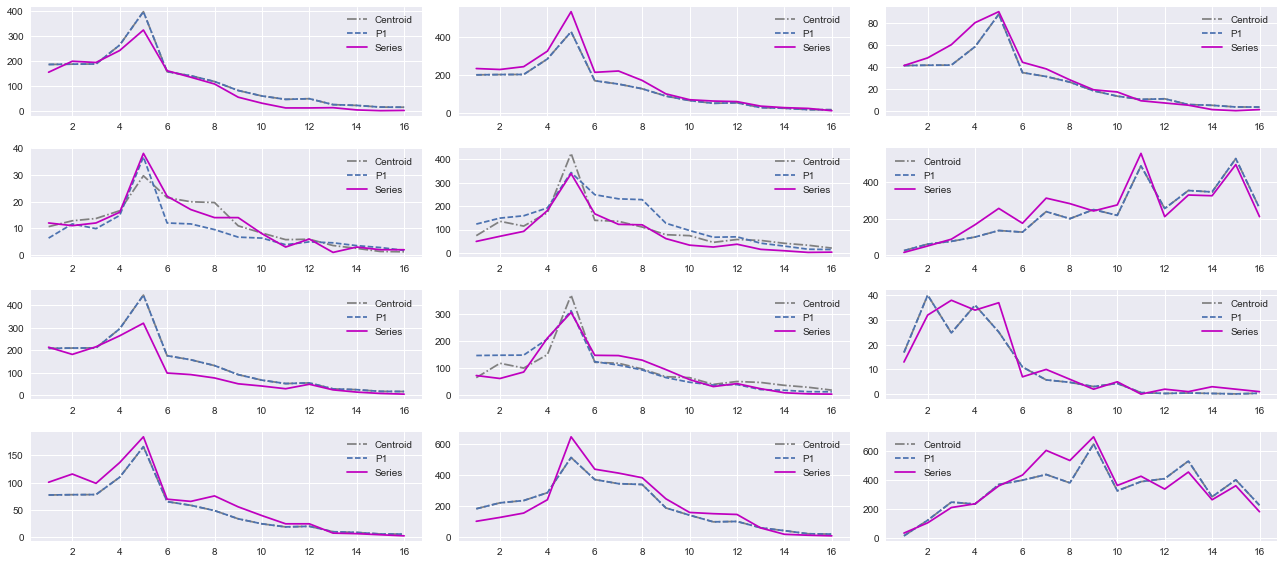

In [235]:
display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))


i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction

    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    plt.subplot(4,3,i)
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    
    best = disp.loc[index].Best
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.plot(p1,label="P1",ls='--')
    
    plt.plot(series,label="Series",c='m')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     plt.plot(p4,label="P4",ls='--')



    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

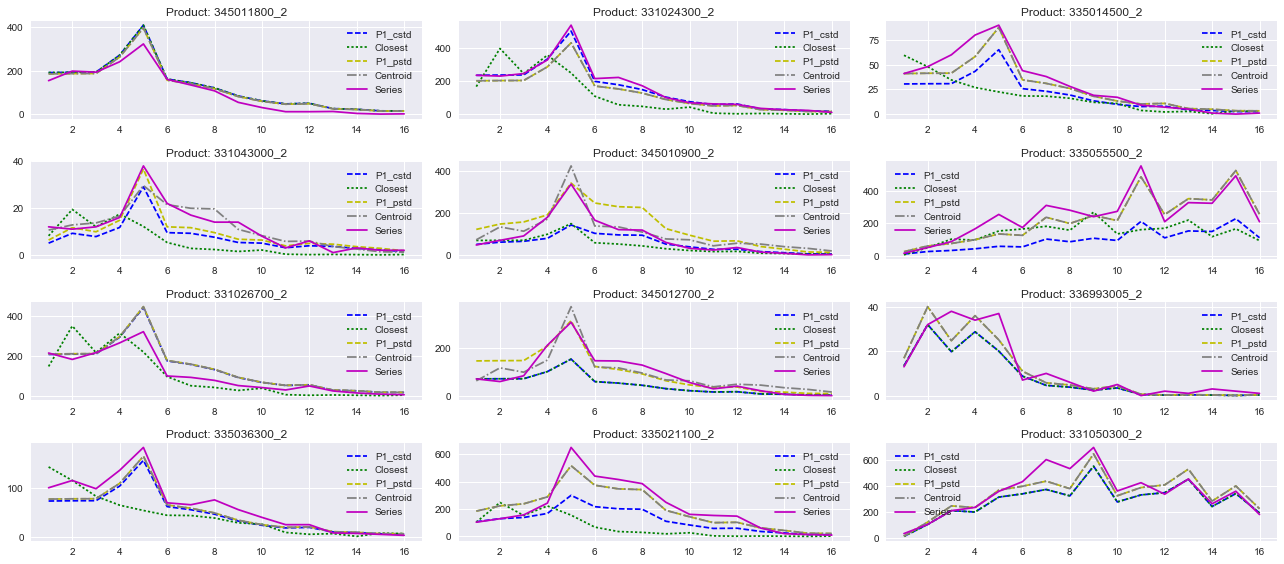

In [236]:
import imp

from visualization import classification_analysis as ca
%aimport visualization.classification_analysis
imp.reload(settings)
imp.reload(visualization.classification_analysis)



ca.predictions_plot(display_result,series_df, standard = False, nearest = True)

plt.show()

### Adjusted Prediction

,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,10,11,12,13,14,15,16,R2,RMSE,Best
Product,,,,,,,,,,,,,,,,,,,,,
345011800_2,9,5,8,12,331032200_2,335025200_2,337015200_2,331032500_2,9,331032200_2,...,31.0,12.0,12.0,13.0,4.0,1.0,2.0,0.928355,6.879047,0
331024300_2,9,7,1,8,331032200_2,335011700_2,331050900_2,337015200_2,9,331032200_2,...,69.0,62.0,59.0,35.0,27.0,23.0,11.0,0.869401,10.018708,0
335014500_2,9,7,5,6,331032200_2,335011700_2,335025200_2,331700300_2,9,331032200_2,...,17.0,9.0,7.0,5.0,1.0,0.0,1.0,0.869286,2.048750,0
331043000_2,12,9,7,5,331032500_2,331032200_2,335011700_2,335025200_2,5,335025200_2,...,8.0,3.0,6.0,1.0,3.0,2.0,2.0,0.859749,0.749681,3
345010900_2,5,9,8,12,335025200_2,331032200_2,337015200_2,331032500_2,12,331032500_2,...,33.0,25.0,37.0,15.0,9.0,2.0,3.0,0.852791,8.910413,3


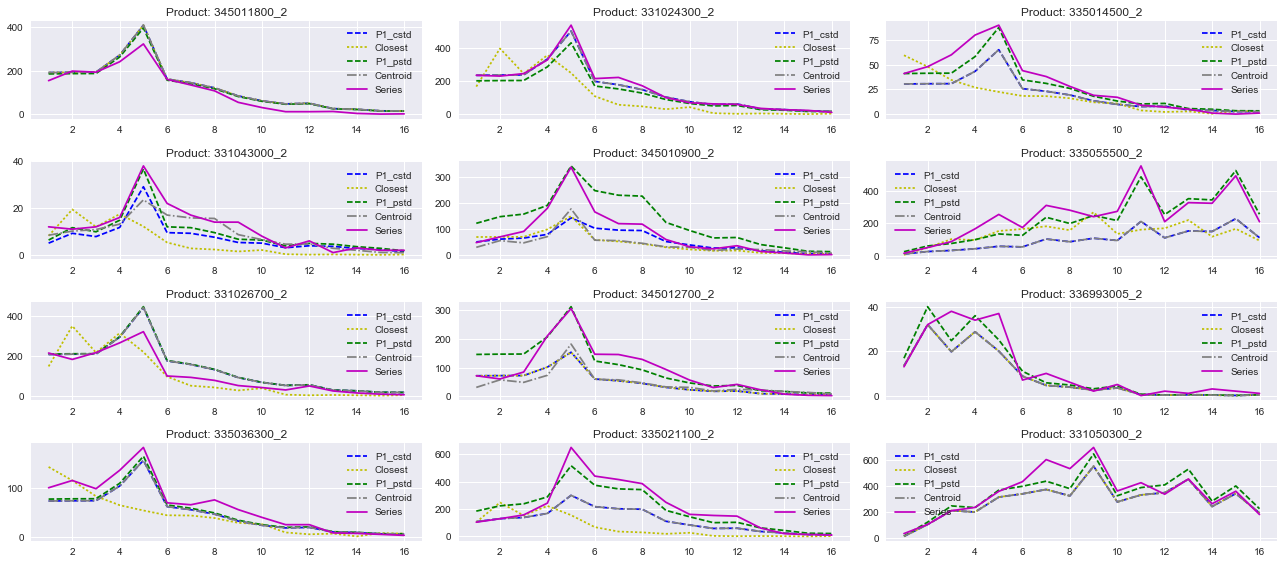

In [242]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

display_result = disp[disp.R2>0].nlargest(disp.shape[0],"R2").iloc[:12,:-3]

display(disp.loc[display_result.index].head())
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = prediction
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    
    
    first_points = series[:n_points]/series[:n_points].std()
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.title("Product: %s" % (index))
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
    cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
    p1c = p1 * cstd 
    p1p = p1 * pstd[0]
    c_series *= cstd
    
    
    plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p_array.iloc[closest]*cstd,label="Closest",c='y',ls=':')
    plt.plot(p1p,label="P1_pstd",ls='--',c='g')
    
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(series,label="Series",c='m')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()

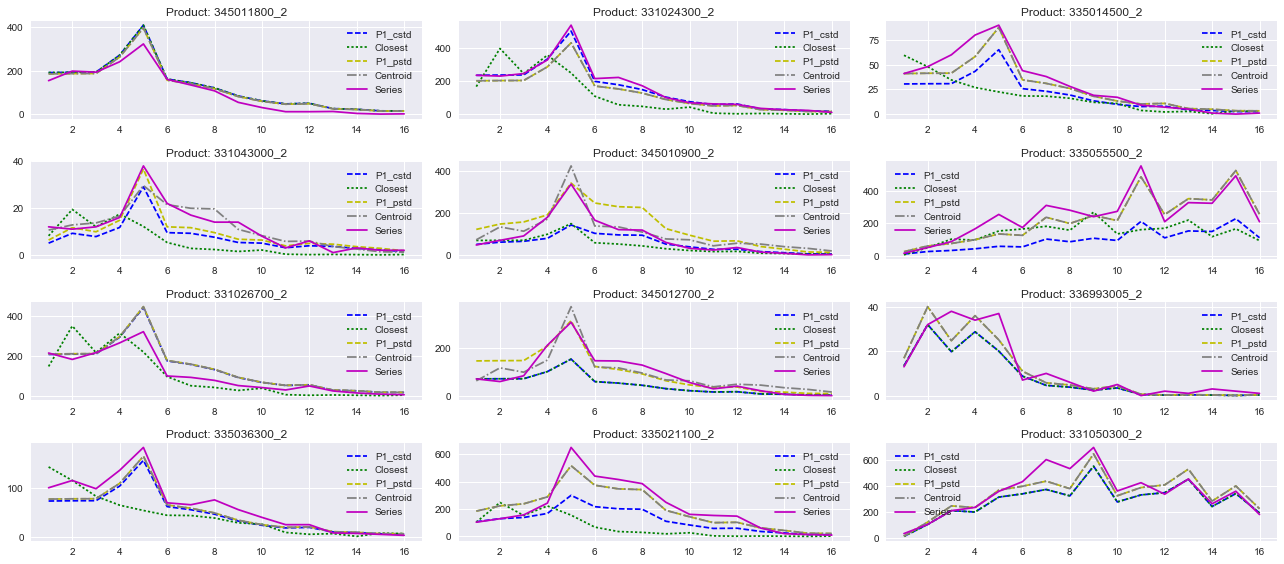

In [238]:




ca.predictions_plot(display_result,series_df, standard = True, nearest = True)

plt.show()